In [30]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
from pathlib import Path
import imgaug as aug
import imgaug.augmenters as iaa
%matplotlib inline

In [21]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5863493775949614454
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4158062592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8008558985919688143
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [22]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 데이터 처리 순서
1. 히스토그램 추출 (배경과 x-ray 차이가 많이 날때 즉 x-ray histogram이 한곳에 몰려있을때)
2. 주파수별 가중치 부여 (히스토그램 추출 할때 고주파 영역이 너무 부자연스러운 경우가 있음 이를조정)
3. 밝기 조절( he , clahe, custom)
4. resize
5. normalization

# Data 경로 지정

In [3]:
data_path = Path('D:\\Data\\SMILE\\chest_xray')
test = data_path / 'test'
train = data_path / 'train'
val = data_path / 'val'

test_normal = test/ 'NORMAL'
test_pneumonia = test/ 'PNEUMONIA'

train_normal = train/ 'NORMAL'
train_pneumonia = train/ 'PNEUMONIA'

val_normal = val/ 'NORMAL'
val_pneumonia = val/ 'PNEUMONIA'



ex_img = train_normal/'IM-0115-0001.jpeg'
Leena = data_path/'Lenna.png'

# 이미지 예시

In [4]:
img = cv2.imread(str(ex_img), cv2.IMREAD_UNCHANGED)  ## 우선은 기존 사진을 불러오는게 맞을듯
cv2.imshow('img', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

# 이미지 분석

(1858, 2090)


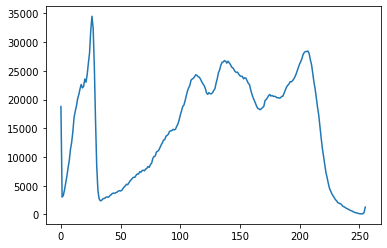

In [5]:
print(img.dtype) ##bit 수확인
print(img.shape)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)

# 이미지 선명도 조정

In [6]:
def distinction1(img): #clahe girdsize가 크면 클수록 대비가 좋아지긴하나 부자연스러움
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize = (8,8)) 
    return clahe.apply(img)

def distinction2(img): # 히스토그램 평활화
    return cv2.equalizeHist(img)

def distinction3(img): # 고주파 영역 clahe 영향 키우고 저주파영역 he영향 키움 clahe 자연스럽게 만든거라 생각 하면됨
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize = (8,8)) 
    clahe_img = clahe.apply(img)
    he_img = cv2.equalizeHist(img)
    std = img.std()
    for dh in range(0,img.shape[0]-7,8):
        for dw in range(0,img.shape[1]-7,8):
            crop = img[dh:dh+8,dw:dw+8]
            if std >= crop.std(): #상대적으로 저주파 지역
                img[dh:dh+8,dw:dw+8] = clahe_img[dh:dh+8,dw:dw+8]
            else:
                img[dh:dh+8,dw:dw+8] = he_img[dh:dh+8,dw:dw+8]
    return img
        


In [7]:
f_img = img.copy()
cv2.imshow('img', f_img)
cv2.imshow('img1', distinction1(f_img))
cv2.imshow('img2', distinction2(f_img))
cv2.imshow('img3', distinction3(f_img))
cv2.waitKey(0)
cv2.destroyAllWindows()


# 주파수 영역 출출 코드 

In [8]:
img = cv2.imread(str(ex_img), cv2.IMREAD_UNCHANGED)  ## 우선은 기존 사진을 불러오는게 맞을듯
f_img = img.copy()
f_img = cv2.resize(f_img ,dsize=(0,0),fx=0.6,fy=0.6, interpolation = cv2.INTER_AREA)
cv2.imshow('img', f_img)

height ,width = f_img.shape
crow , ccol = int(height/2), int(width/2)
dh, dw = int(height/20), int(width/20)

img_zip = []
for i in range(1,11):
        
    background = np.zeros((height, width),dtype= int)
    f = np.fft.fft2(f_img)
    fshift = np.fft.fftshift(f)
    fshift2 = fshift.copy()
    if i == 1:
        fshift[crow-(dh*i):crow+(dh*i),ccol-(dw*i):ccol+(dw*i)] = 0
        fshift2 = fshift2 - fshift
    elif i ==10:
        fshift[crow-(dh*(i-1)):crow+(dh*(i-1)),ccol-(dh*(i-1)):ccol+(dh*(i-1))] = 0
        fshift2 = fshift2 - fshift
    else: 
        fshift[crow-dh*(i-1):crow+dh*(i-1),ccol-dw*(i-1):ccol+dw*(i-1)] = 0
        fshift2[crow-(dh*i):crow+(dh*i),ccol-(dw*i):ccol+(dw*i)] = 0
        fshift2 = fshift -  fshift2
    f_ishift = np.fft.ifftshift(fshift2)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_zip.append(img_back)
    
weight_img = np.zeros(f_img.shape, np.float32 )
print(weight_img.shape)
for i, _img in enumerate(img_zip):
    if i <3 :
        weight_img = weight_img + 1.2*_img
    elif (i>=3)and(i<7):
        weight_img = weight_img + 1.8*_img
    else:
        weight_img = weight_img + 0.6*_img
        
weight_img = weight_img.astype('uint8')
cv2.imshow('weight_img', weight_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1115, 1254)


# image resize

In [9]:
def img_resize1(img,w,h):  # padding을 통해 size 맞춤
    if((w/img.shape[1]) < h/img.shape[0]):
        percent = w/img.shape[1]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_LINEAR)
        dh = (h-img.shape[0])/2
        M = np.array([[1,0,0],[0,1,dh]],dtype=np.float64)  
        img = cv2.warpAffine(img, M, (w, h))
    else:
        percent = h/img.shape[0]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_LINEAR)
        dw = (w-img.shape[1])/2
        M = np.array([[1,0,dw],[0,1,0]],dtype=np.float64)  
        img = cv2.warpAffine(img, M, (w, h))
    return img
        
def img_resize2(img,w,h): #crop을 통해 size 맞춤
    if((w/img.shape[1]) > h/img.shape[0]):
        percent = w/img.shape[1]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_LINEAR)
        print("1",img.shape[0])
        dh = (img.shape[0]-h)//2
        img = img[dh:dh+h,:].copy()
    else:
        percent = h/img.shape[0]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_LINEAR)
        print("2",img.shape[1])
        dw = (img.shape[1]-w)//2
        img = img[:,dw:dw+w].copy()
    return img
    
def img_resize3(img,w,h):  # resize1과 동일 보간법 차이
    if((w/img.shape[1]) < h/img.shape[0]):
        percent = w/img.shape[1]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_AREA)
        dh = (h-img.shape[0])/2
        M = np.array([[1,0,0],[0,1,dh]],dtype=np.float64)  
        img = cv2.warpAffine(img, M, (w, h))
    else:
        percent = h/img.shape[0]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_AREA)
        dw = (w-img.shape[1])/2
        M = np.array([[1,0,dw],[0,1,0]],dtype=np.float64)  
        img = cv2.warpAffine(img, M, (w, h))
    return img
        
def img_resize4(img,w,h): #resize2과 동일 보간법 차이
    if((w/img.shape[1]) > h/img.shape[0]):
        percent = w/img.shape[1]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_AREA)
        print("1",img.shape[0])
        dh = (img.shape[0]-h)//2
        img = img[dh:dh+h,:].copy()
    else:
        percent = h/img.shape[0]
        img = cv2.resize(img,dsize=(0,0),fx=percent,fy=percent, interpolation = cv2.INTER_AREA)
        print("2",img.shape[1])
        dw = (img.shape[1]-w)//2
        img = img[:,dw:dw+w].copy()
    return img

In [10]:
# test
f_img = img.copy()
cv2.imshow('before', f_img)
f_img1 = img_resize1(f_img,600,500)
f_img2 = img_resize3(f_img,600,500)
print(f_img2.shape)
cv2.imshow('after1', f_img1)
cv2.imshow('after2', f_img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

(500, 600)


In [11]:
f_img = img.copy()
f_img2 = img_resize2(f_img,600,500)
cv2.imshow('img', f_img2)
cv2.imshow('img1', distinction1(f_img2))
cv2.imshow('img2', distinction2(f_img2))
cv2.imshow('img3', distinction3(f_img2))
cv2.waitKey(0)
cv2.destroyAllWindows()

1 533


# normalization

In [12]:
def norm1(img):
    img = (img.astype(np.float32)-img.min())/(img.max()-img.min())
    return img

def norm2(img):
    img = (img.astype(np.float32) - img.mean())/(img.std())
    return img
    

(array([[130., 575.,  52., ...,   0.,   0.,  15.],
        [117., 583.,  51., ...,   0.,   1.,  14.],
        [104., 589.,  59., ...,   0.,   0.,  15.],
        ...,
        [ 56., 528., 162., ...,   0.,   0.,  15.],
        [ 63., 518., 156., ...,   0.,   1.,  14.],
        [ 57., 530., 150., ...,   0.,   0.,  15.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1496 BarContainer objects>)

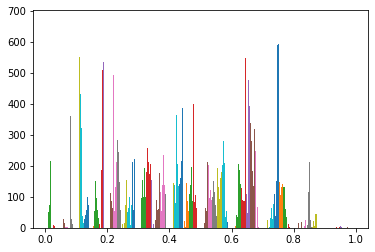

In [28]:
f_img = img.copy()
f_img = norm1(f_img)
plt.hist(f_img)


# augmentation

In [37]:
aug_seq =  iaa.Sequential([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=(20,60),
               translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
              shear=(-16, 16)), # roatation
    iaa.Multiply((1.2, 1.5))] #random brightness
    ,random_order=True)

In [40]:
ex_img = train_normal/'IM-0115-0001.jpeg'
ex_img = cv2.imread(str(ex_img), cv2.IMREAD_UNCHANGED)
aug_img = aug_seq.augment_image(ex_img)
cv2.imshow('aug_img', aug_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data generator1 (이미지 np.array 형태로 반환)

In [45]:
def pretreatment(path, class_id, per):

    data = []
    labels = []
    for img in path:
        img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
        img = distinction3(img) ## 선명도 높이기
        img = img_resize3(img,224,224) ## 수정 필요
        
        origin_img = norm1(img) ## 정규화 
        origin_img = np.dstack([origin_img])
        
        label = to_categorical(class_id, num_classes=2) ## 수정 필요
        
        data.append(origin_img)
        labels.append(label)
        
        for i in range(per):
            aug_img = aug_seq.augment_image(img)
            aug_img = norm1(aug_img)
            aug_img = np.dstack([aug_img])
            data.append(aug_img)
            labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels



In [54]:
normal_cases = val_normal.glob('*.jpeg')
pneumonia_cases = val_pneumonia.glob('*.jpeg')
img, label = pretreatment(normal_cases, 0, 2)
for i in range (0,len(img)):
    cv2.imshow('aug_img' + str(i), img[i])
    
cv2.waitKey(0)
cv2.destroyAllWindows()


# Data generator2 (batch 단위 이미지 generator 반환)

In [36]:
def data_gen(data, batch_size, img_size):
    n = len(data)
    steps = n//batch_size
    
    
    batch_data = np.zeros((batch_size,img_size[0],img_size[1],1), dtype=np.float32)
    batch_labels =np.zeros((batch_size,2), dtype=np.float32) ## 수정필요
    
    indices = np.arange(n)
    np.random.shuffle(indices)
    i = 0
    while True:
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            encoded_label = to_categorical(label, num_classes=2) ## 수정 필요
            
            img = cv2.imread(str(img_name), cv2.IMREAD_GRAYSCALE)
            img = distinction3(img) ## 선명도 높이기
            img = img_resize3(img,img_size[1],img_size[0]) ## img resize
            img = norm1(img) ## 정규화
            img = np.dstack([img]) ## 차원 맞추기
            batch_data[count] = img
            batch_labels[count] = encoded_label
            
            count +=1
            if count==batch_size -1:
                break
        i += 1
        yield batch_data, batch_labels
        
        if i>=steps:
            i=0
            np.random.shuffle(indices)

# train  데이터 만들기

<AxesSubplot:xlabel='label', ylabel='count'>

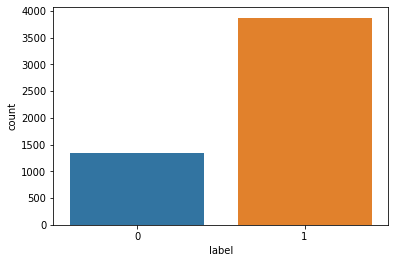

In [15]:
norm_cases = train_normal.glob('*.jpeg')
pneumonia_cases = train_pneumonia.glob('*.jpeg')

train_data = []
for img in norm_cases:
    train_data.append((img, 0))
    
for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'], index = None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)
sns.countplot(x='label', data=train_data)


# validation 데이터 만들기

In [16]:
# 배운점 
    #os.listdir = 해당 디렉토리 파일명만 가져옴
    #glob = 해당 디렉토리의 경로명까지 가져옴 ->내생각엔 사진을 불러오는 느낌이라기 보단 경로를 불러오는 느낌
    #glob 은 generator를 반환함 
    #dstack, stack, concatenate 차이 

normal_cases = val_normal.glob('*.jpeg')
pneumonia_cases = val_pneumonia.glob('*.jpeg')

valid_data = []
valid_labels = []

for img in normal_cases:
    img = cv2.imread(str(img), cv2.IMREAD_UNCHANGED)
    img = distinction3(img) ## 선명도 높이기
    img = img_resize3(img,224,224) ## img resize
    img = norm1(img) ## 정규화 
    img = np.dstack([img])
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img), cv2.IMREAD_UNCHANGED)
    img = distinction3(img) ## 선명도 높이기
    img = img_resize3(img,224,224) ## img resize
    img = norm1(img) ## 정규화
    img = np.dstack([img])
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("image 2 ", valid_data[1].shape)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)


image 2  (224, 224, 1)
Total number of validation examples:  (16, 224, 224, 1)
Total number of labels: (16, 2)


# Model 구현

In [18]:
#배운점
    #3*3 kernel 을 사용하면 왜 7*7 보다 파라미터가 줄어드는지
    # adam 최적화 기법 : 관성과 변수별 학습률을 고려한 최적의 최적화기법
    # relu singmoid -> 이진분류 identity -> 회귀
    # batch normal -> 
    # 기울기 소실문제 합성 함수의 미분을 구하는것은 계속해서 곱해나간단 소린데 1보다작은수를 계속 곱해나가면 기울기가 계속 줄어듬
    # ? 왜 모델이 깊어질수록 비선형성이 증가하는가
    # ? 왜 channel을 점점 키우는 걸까 키우면 왜 보통 2배씩 커지지
from keras.layers import BatchNormalization
def build_model():
    input_img = Input(shape=(224,224,1), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 1)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      640       
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

# Model 학습

In [20]:
#배우점 
    # keras 함수가 다함
    # model (compile, fit_generator) , earlystopping, modelcheckpoint
    #fit fit_generator 차이 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', monitor = 'loss', mode = 'min' , save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
batch_size = 16
nb_epochs = 20
size = [224,224]
# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size ,img_size = size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                               class_weight={0:1.0, 1:0.4})

Number of training and validation steps: 326 and 16


C:\Users\s_ex9845\AppData\Local\Temp/ipykernel_9312/3745474607.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,


KeyboardInterrupt: 

In [26]:
model.load_weights("best_model_todate")

test_normal = test/ 'NORMAL'
test_pneumonia = test/ 'PNEUMONIA'

normal_cases = test_normal.glob('*.jpeg')
pneumonia_cases = test_pneumonia.glob('*.jpeg')
test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = distinction3(img) ## 선명도 높이기
    img = img_resize3(img,224,224) ## 수정 필요
    origin_img = norm1(img) ## 정규화 
    origin_img = np.dstack([origin_img])    
    label = to_categorical(0, num_classes=2) ## 수정 필요
    
    test_data.append(origin_img)
    test_labels.append(label)
    
for img in pneumonia_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = distinction3(img) ## 선명도 높이기
    img = img_resize3(img,224,224) ## 수정 필요
    origin_img = norm1(img) ## 정규화 
    origin_img = np.dstack([origin_img])    
    label = to_categorical(1, num_classes=2) ## 수정 필요
    
    test_data.append(origin_img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)




KeyboardInterrupt: 

In [ ]:
aug_seq =  iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=(20,60)
               translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
              shear=(-16, 16)), # roatation
    iaa.Multiply((1.2, 1.5))] #random brightness
    ,random_order=True)